# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 15.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../autotalker")

In [2]:
import os
from datetime import datetime

import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scib

from autotalker.benchmarking import compute_benchmarking_metrics

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 46432), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 46434), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 46450), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/c

### 1.2 Define Parameters

In [3]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
spatial_key = "spatial"
random_seed = 0

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/method_benchmarking/{dataset}/"
artifact_folder_path = f"../artifacts/method_benchmarking/{dataset}/"

In [7]:
# Create required directories
os.makedirs(artifact_folder_path, exist_ok=True)

### 1.5 Define Functions

In [8]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          spatial_model,
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          cell_type_key="celltype_mapped_refined"):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         spatial_model=spatial_model,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         active_gp_names_key=f"{model_name}_active_gp_names_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key=spatial_key,
                                                         spatial_knng_key = f"{model_name}_spatial_{n_neighbors}nng",
                                                         latent_knng_key = f"{model_name}_latent_{n_neighbors}nng",
                                                         n_neighbors=n_neighbors)

        # Compute scib metrics
        sc.pp.neighbors(adata=model_adata,
                        use_rep=f"{model_name}_latent_run{run_number}",
                        n_neighbors=15) # default
        scib.me.cluster_optimal_resolution(adata=model_adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
        benchmarking_dict["ari"] = scib.me.ari(model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["clisi"] = scib.me.clisi_graph(adata=model_adata,
                                                         label_key=cell_type_key,
                                                         type_="embed",
                                                         use_rep=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["nmi"] = scib.me.nmi(adata=model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["asw"] = scib.me.silhouette(adata=model_adata,
                                                      label_key=cell_type_key,
                                                      embed=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["isolated_labels_asw"] = scib.me.isolated_labels_asw(adata=model_adata,
                                                                               batch_key="sample",
                                                                               label_key=cell_type_key,
                                                                               embed=f"{model_name}_latent_run{run_number}")
        
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

## 2. Data

In [86]:
# Load data after running all notebooks in the 'method_benchmarking' folder
adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")

## 3. Method Benchmarking

- Run all notebooks in the ```method_benchmarking``` directory before continuing.

### 3.1 Latent Space Comparison

In [87]:
n_neighbors = 12

# Baseline
sc.pp.neighbors(adata_pca, use_rep=f"pca_latent_run1", n_neighbors=n_neighbors)
sc.tl.umap(adata_pca, min_dist=0.3)

# Methods
run_number = 4
for adata, method in zip([adata_scvi, adata_expimap, adata_sagenet, adata_deeplinc, adata_graphst, adata_autotalker],
                         ["scvi", "expimap", "sagenet", "deeplinc", "graphst", "autotalker"]):
    sc.pp.neighbors(adata, use_rep=f"{method}_latent_run{run_number}", n_neighbors=n_neighbors)
    sc.tl.umap(adata, min_dist=0.3)

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The 

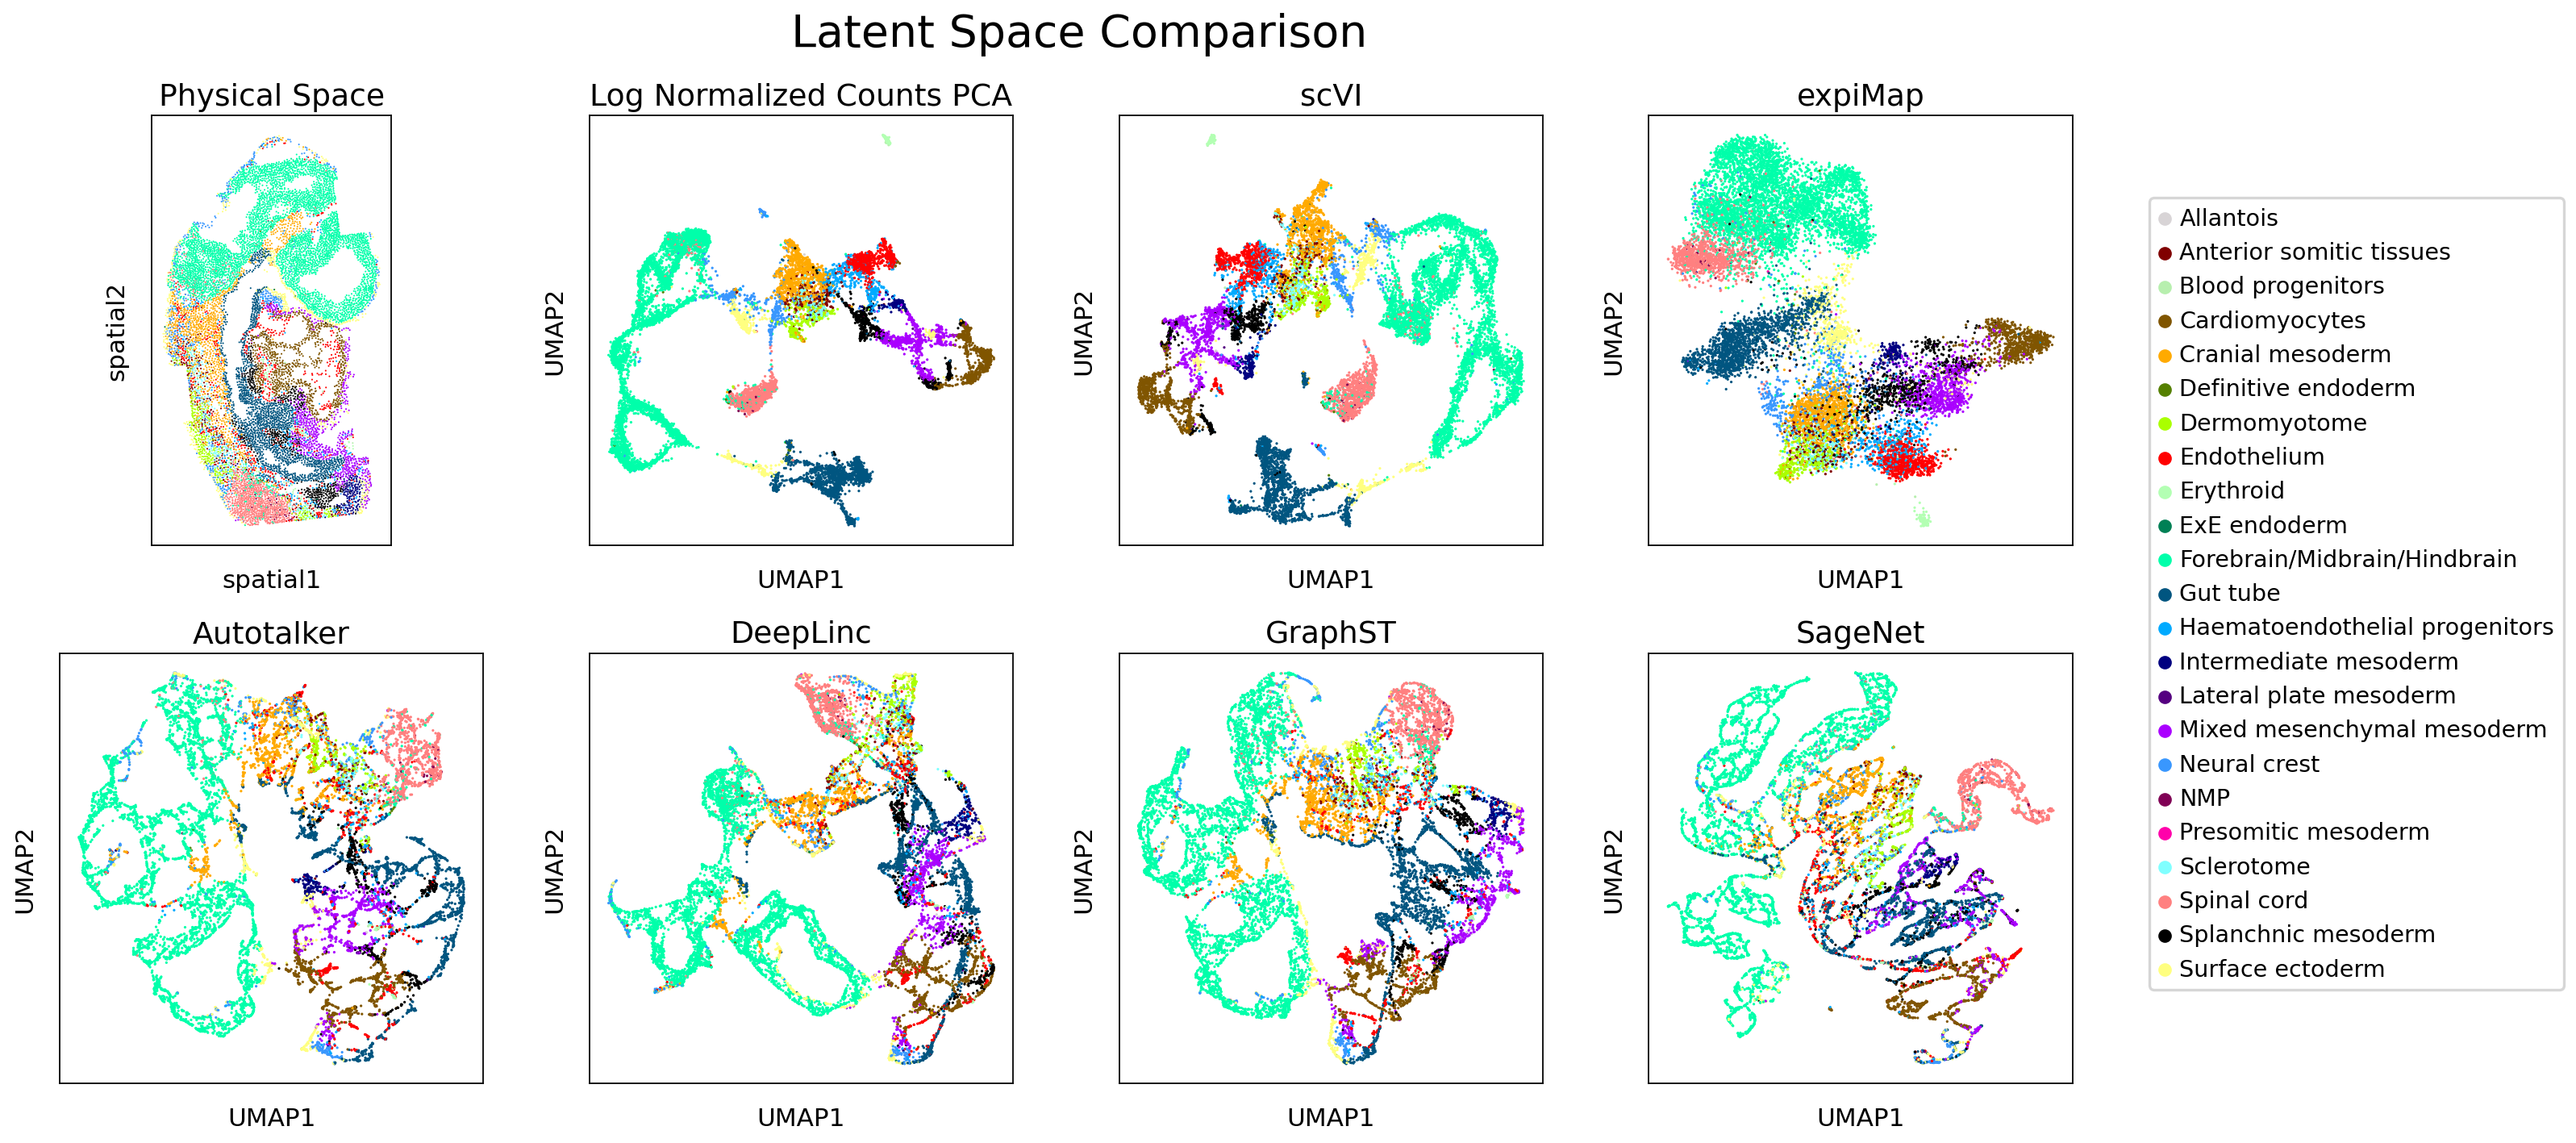

In [89]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
plt.suptitle("Latent Space Comparison", fontsize=25, x=0.575)
plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.9)
axs=axs.flatten()

sc.pl.spatial(adata=adata,
              color=[cell_type_key],
              spot_size=0.03,
              ax=axs[0],
              show=False)
axs[0].set_title("Physical Space", fontsize=17)
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(1.07, 0.845))
axs[0].get_legend().remove()
                         
for i, (adata, title) in enumerate(zip([adata_pca, adata_scvi, adata_expimap, adata_autotalker, adata_deeplinc, adata_graphst, adata_sagenet],
                                       ["Log Normalized Counts PCA", "scVI", "expiMap", "Autotalker", "DeepLinc", "GraphST", "SageNet"])):        
    sc.pl.umap(adata,
               color=[cell_type_key],
               ax=axs[i + 1],
               show=False,
               legend_loc=None)
    axs[i + 1].set_title(title, fontsize=17)

fig.savefig(f"{figure_folder_path}/latent_comparison_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()

### 3.2 Benchmarking Metrics

#### 3.2.1 PCA

- Evaluate PCA of log normalized gene expression.

In [10]:
benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                   model_name="pca",
                                                                   spatial_model=False,
                                                                   run_number_list=[1],
                                                                   n_neighbors_list=[12],
                                                                   cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.6695952741187797
resolution: 0.2, nmi: 0.7385439836334321
resolution: 0.3, nmi: 0.7123739081526013
resolution: 0.4, nmi: 0.7077612436556762
resolution: 0.5, nmi: 0.679065216143822
resolution: 0.6, nmi: 0.689482435231807
resolution: 0.7, nmi: 0.6772664116869933
resolution: 0.8, nmi: 0.6699740233005426
resolution: 0.9, nmi: 0.6741417815701275
resolution: 1.0, nmi: 0.6738611900287442
resolution: 1.1, nmi: 0.6715452341100905
resolution: 1.2, nmi: 0.6645002353577019
resolution: 1.3, nmi: 0.6596491788450072
resolution: 1.4, nmi: 0.6656020307195687
resolution: 1.5, nmi: 0.6586871427428685
resolution: 1.6, nmi: 0.6485736922944785
resolution: 1.7, nmi: 0.6530264394856284
resolution: 1.8, nmi: 0.6527707929669109
resolution: 1.9, nmi: 0.6466768902310875
resolution: 2.0, nmi: 0.6482103286156078
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.7385439836334321
isolated labels: no more than 1 batches per label
Allantois: 0.

In [26]:
benchmarking_dict_list = benchmarking_dict_list_pca

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

# Clean from memory
del(adata_pca)

#### 3.2.2 scVI

- Evaluate scVI.

In [13]:
benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                    model_name="scvi",
                                                                    spatial_model=False,
                                                                    run_number_list=list(np.arange(1, 11)),
                                                                    n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                    cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.6510112755134858
resolution: 0.2, nmi: 0.6907614873560975
resolution: 0.3, nmi: 0.6887016496029861
resolution: 0.4, nmi: 0.6497561698382365
resolution: 0.5, nmi: 0.6714500541419256
resolution: 0.6, nmi: 0.6434150067935084
resolution: 0.7, nmi: 0.6377239649706704
resolution: 0.8, nmi: 0.6581777770337697
resolution: 0.9, nmi: 0.6484701775225603
resolution: 1.0, nmi: 0.63894088043837
resolution: 1.1, nmi: 0.6396198862517618
resolution: 1.2, nmi: 0.6359441530581543
resolution: 1.3, nmi: 0.627887869115528
resolution: 1.4, nmi: 0.6241053306020455
resolution: 1.5, nmi: 0.6290970674247918
resolution: 1.6, nmi: 0.6208974400448526
resolution: 1.7, nmi: 0.6177545246548721
resolution: 1.8, nmi: 0.6199699169778355
resolution: 1.9, nmi: 0.607065641579197
resolution: 2.0, nmi: 0.6144378835869146
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.6907614873560975
isolated labels: no more than 1 batches per label
Allantois: 0.48

In [27]:
benchmarking_dict_list += benchmarking_dict_list_scvi

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

# Clean from memory
del(adata_scvi)

#### 3.2.3 expiMap

- Evaluate expiMap.

In [28]:
benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                       model_name="expimap",
                                                                       spatial_model=False,
                                                                       run_number_list=list(np.arange(1, 11)),
                                                                       n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                       cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.4089409237536028
resolution: 0.2, nmi: 0.5939560071392522
resolution: 0.3, nmi: 0.6217577026063992
resolution: 0.4, nmi: 0.6339314908378714
resolution: 0.5, nmi: 0.668790678907316
resolution: 0.6, nmi: 0.6883543171754272


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/leidenalg/Optimiser.py:7: DeprecationWarning: invalid escape sequence \g
  """ Class for doing community detection using the Leiden algorithm.
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/leidenalg/Optimiser.py:305: DeprecationWarning: invalid escape sequence \s
  """ Optimise the given partitions simultaneously.


KeyboardInterrupt: 

In [ ]:
del(adata_expimap)

#### 3.2.4 SageNet

- Evaluate SageNet.
- Run ```method_benchmarking/sagenet/sagenet.ipynb``` before evaluation.

In [ ]:
del(adata_sagenet)

#### 3.2.5 DeepLinc

In [9]:
benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                        model_name="deeplinc",
                                                                        spatial_model=True,
                                                                        run_number_list=list(np.arange(1, 2)),
                                                                        n_neighbors_list=[4],
                                                                        cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43625205848769655
resolution: 0.2, nmi: 0.4256497541226183
resolution: 0.3, nmi: 0.4354678447390657
resolution: 0.4, nmi: 0.4485325608489123
resolution: 0.5, nmi: 0.4475305564455195
resolution: 0.6, nmi: 0.44626262488014123
resolution: 0.7, nmi: 0.4494230780105263
resolution: 0.8, nmi: 0.4456513556761488
resolution: 0.9, nmi: 0.4431506552761424
resolution: 1.0, nmi: 0.4444155442721347
resolution: 1.1, nmi: 0.4439504771040337
resolution: 1.2, nmi: 0.4466912134575003
resolution: 1.3, nmi: 0.4407771257462492
resolution: 1.4, nmi: 0.4483105432868993
resolution: 1.5, nmi: 0.4520939220675786
resolution: 1.6, nmi: 0.4489948038021931
resolution: 1.7, nmi: 0.4467223731441045
resolution: 1.8, nmi: 0.4514085671173903
resolution: 1.9, nmi: 0.4491425220828568
resolution: 2.0, nmi: 0.45359524591392275
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 2.0
optimal score: 0.45359524591392275
isolated labels: no more than 1 batches per label
Allanto

In [ ]:
del(adata_deeplinc)

#### 3.2.6 GraphST

In [ ]:
benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                       model_name="graphst",
                                                                       spatial_model=True,
                                                                       run_number_list=list(np.arange(1, 2)),
                                                                       n_neighbors_list=[4],
                                                                       cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_graphst)

#### 3.2.7 Autotalker

In [ ]:
adata_autotalker.write(f"{data_folder_path}/{dataset}_autotalker.h5ad") 

In [ ]:
benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                          model_name="autotalker",
                                                                          spatial_model=True,
                                                                          run_number_list=list(np.arange(1, 2)),
                                                                          n_neighbors_list=[4],
                                                                          #run_number_list=list(np.arange(1, 11)),
                                                                          #n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                          cell_type_key="celltype_mapped_refined")

In [ ]:
del(adata_autotalker)

#### 3.2.8 Summary

In [ ]:
benchmarking_dict_list = (benchmarking_dict_list_pca
                          + benchmarking_dict_list_scvi
                          + benchmarking_dict_list_expimap
                          # + benchmarking_dict_list_sagenet)
                          + benchmarking_dict_list_deeplinc
                          + benchmarking_dict_list_graphst
                          + benchmarking_dict_list_autotalker)

In [10]:
benchmarking_dict_list = benchmarking_dict_list_deeplinc

In [11]:
df = pd.DataFrame(benchmarking_dict_list)
df.head()

,gcd,mlnmi,cad,arclisi,germse,cca,ari,clisi,nmi,asw,isolated_labels_asw,model_name,run
0,214.683243,0.792441,51.780208,0.0,0.249541,0.850335,0.100362,0.980299,0.453595,0.464343,0.505143,deeplinc,1


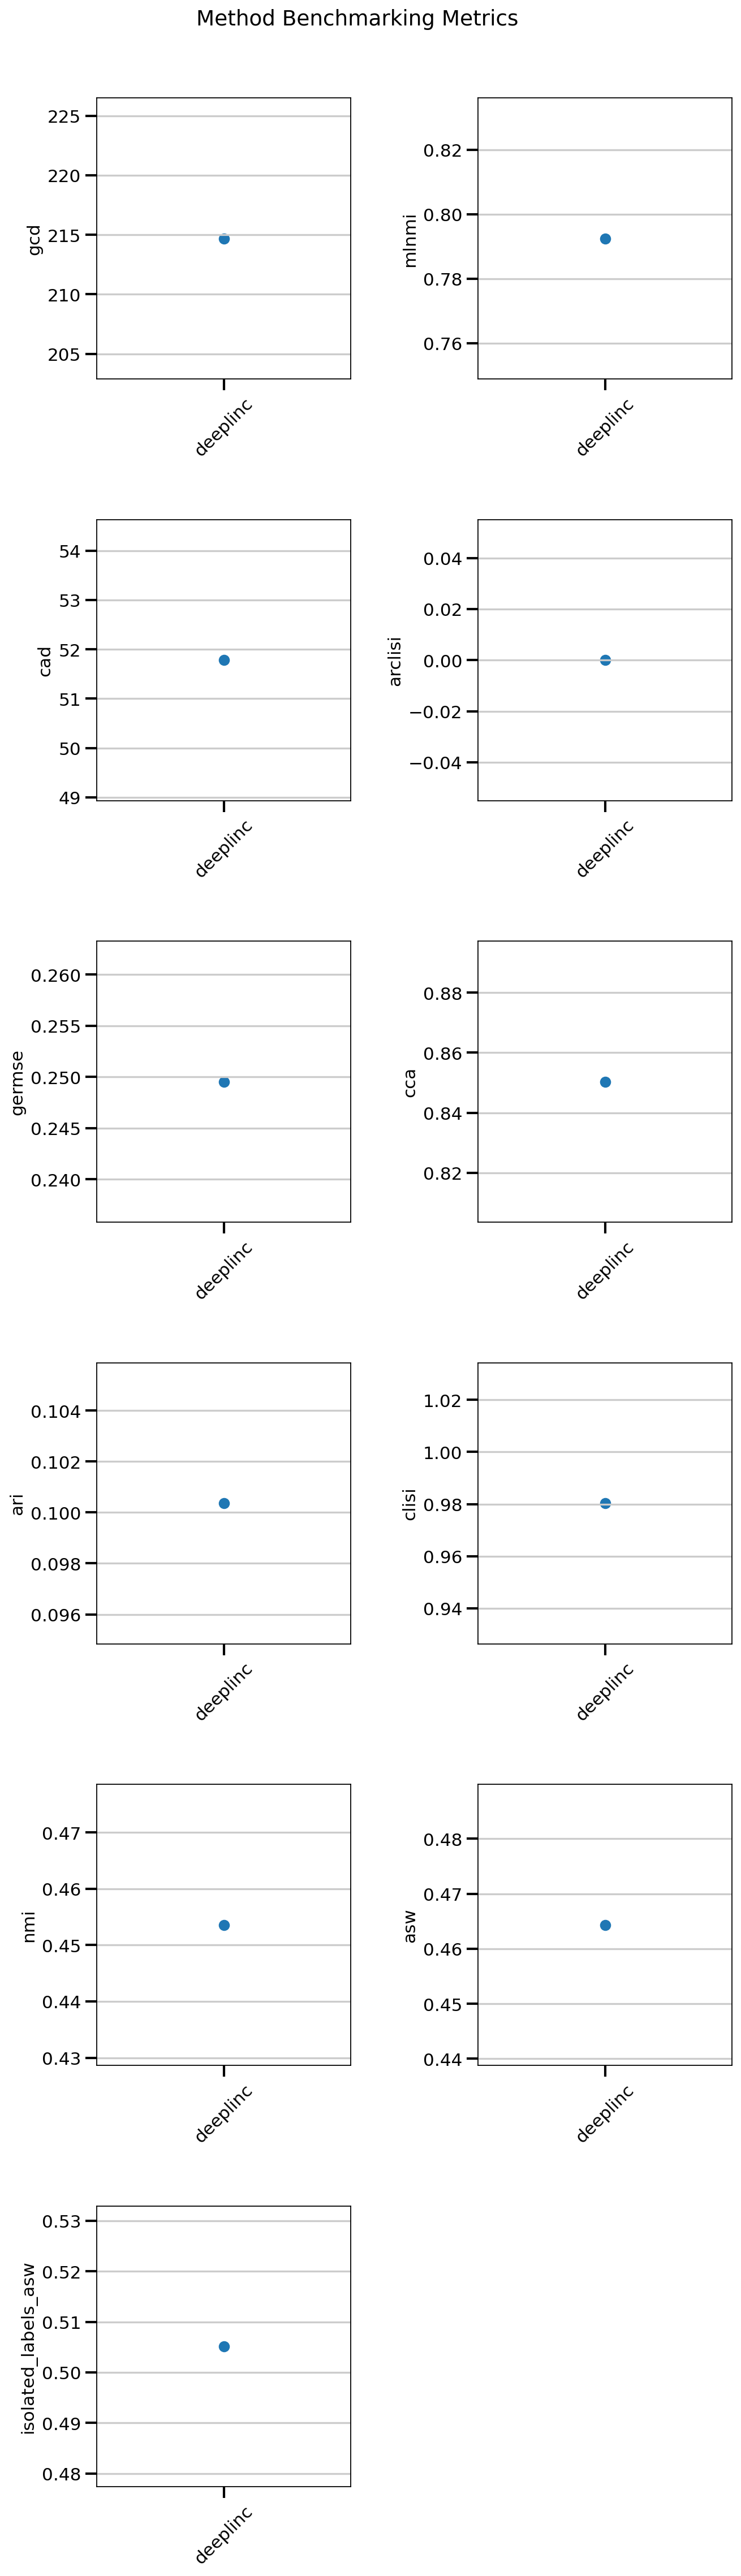

In [13]:
mean_df = df.groupby("model_name").mean()

columns = ["gcd",
           "mlnmi",
           "cad",
           "arclisi",
           "germse",
           "cca",
           "ari",
           "clisi",
           "nmi",
           "asw",
           "isolated_labels_asw"]


fig, axs = plt.subplots(nrows=int(np.ceil(len(columns)/2)), ncols=2, figsize=(9, 3*len(columns)))
axs=axs.flatten()

for i, col in enumerate(columns):
    sns.pointplot(data=mean_df, x=mean_df.index, y=col, ax=axs[i])
    axs[i].set_xlabel('')
    xlabels = axs[i].get_xticks()
    axs[i].set_xticklabels(mean_df.index, rotation=45)
plt.suptitle("Method Benchmarking Metrics")
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.95)

if len(columns) % 2 != 0:
    fig.delaxes(axs[-1])

plt.show()